<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/best%20channel/1%20ch(61.%20Oz).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
'''
1 channel :  61 (index =Oz)

layers: 3 conv2D(3,3) & maxpooling(2,2)
epoch: 20 
batch size: 20

test acc: 0.8891
test loss: 0.4475
'''


import matplotlib
from matplotlib import pyplot as plt
import numpy as np


import random
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
#from mne.datasets import testing
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)


1 channel :  61 (index =Oz)

layers: 3 conv2D(3,3) & maxpooling(2,2)
epoch: 20 
batch size: 20

test acc: 0.
test loss: 0.



In [1]:
!pip install mne

     |████████████████████████████████| 6.3MB 3.4MB/s 
  Created wheel for mne: filename=mne-0.18.2-cp36-none-any.whl size=6316005 sha256=0e16de17aecca42bfb671414b9ee0bbffcb0f7eb72c441971336ec6cc365f826
  Stored in directory: /root/.cache/pip/wheels/71/40/30/fb9a9bdeac02c6b3b144be66ac345c5b5587a7d7610564535b
Successfully built mne


In [70]:
subject_number=20


# load dataset in array
list_raw_fnames = [[0]*2]*subject_number
for x in range(subject_number):
    list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,[1,2])

list_rawdata1 = np.zeros((subject_number,2), dtype='object')
list_rawdata = np.zeros((subject_number,2), dtype='object')

for i in range(subject_number):
    for j in range(2):
        list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)
       

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extr

In [71]:
import math


task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
sample_shift = 4 #step len
window_len= 20
list_channel = [61] # channel = Oz

# img for each one
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec) / sample_shift) +1 - window_len +1
test_start_index=subject_img_number - math.floor(subject_img_number/4) 

train_number =  test_start_index 
test_number = subject_img_number - test_start_index
train_number

1757

In [72]:
ch_number = len(list_channel)

train_img = np.zeros((train_number*subject_number, ch_number, window_len + 1, 160), dtype = float)
train_label =[]


test_img = np.zeros((test_number*subject_number, ch_number, window_len, 160), dtype = float)
test_label =[]


train_img.shape


(35140, 1, 21, 160)

In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

In [0]:
for s in range(subject_number):
    ch_max =[]
    ch_min =[]
    for ch in list_channel:
      rawdataChannels_t, times_t =list_rawdata[s][0][ch,:9600]
      #print(rawdataChannels_t)
      ch_max = np.append(ch_max, max(rawdataChannels_t[0])) # max for each cannel
      ch_min = np.append(ch_min, min(rawdataChannels_t[0])) # min for each cannel
    
    for j in range (subject_img_number):
        i = 0
        for index in list_channel: # فقط کانال های با اندیس مشخص را دربرمیگیرد
            
            for z in range (window_len):
                rawdataChannels, times =list_rawdata[s][0][index, (j+z)*sample_shift:sampel_number_per_sec+(j+z)*sample_shift]

                      # normalize method
                rawdataChannels = normalize_channel_data(rawdataChannels, i, ch_min, ch_max)
                if j <test_start_index :
                    train_img[s*train_number + j][i][z] = rawdataChannels
                    if z==window_len-1 :
                      train_img[s*train_number + j][i][z+1] = s
                      
                      
                else:
                    test_img[s*test_number + j - test_start_index][i][z] = rawdataChannels
            i+=1            
                    
              
        if j >=test_start_index :
          test_label = np.append(test_label, (s))

In [0]:
#shaffle train img array
train_img_shuffle = train_img

np.random.shuffle(train_img_shuffle)

In [0]:
train_img_2 = np.zeros((train_number*subject_number, ch_number, window_len, 160), dtype = float)

# img label 
train_img_shuffle_len =len(train_img_shuffle)
for i in range(train_img_shuffle_len):
    train_label = np.append(train_label, (train_img_shuffle[i][0][window_len][0] ))
    for j in range (ch_number):
      train_img_2[i][j] = np.delete(train_img_shuffle[i][j], window_len, axis=0)

In [0]:
from keras.utils import to_categorical

In [0]:
train_label = to_categorical(train_label, subject_number)
test_label = to_categorical(test_label, subject_number)

In [77]:
# valid & train
x_train =train_img_2[:20000]
y_train =train_label[:20000]

x_valid =train_img_2[20000:]
y_valid =train_label[20000:]

x_valid.shape

(15140, 1, 20, 160)

In [78]:
from keras import layers
from keras import models
from keras import regularizers


model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,160), data_format= "channels_first" ))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))
print(model.output.shape)
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))
print(model.output.shape)
model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))


model.add(layers.Flatten())
print(model.output.shape)
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
print(model.output.shape)
model.add(layers.Dense(subject_number, activation = 'softmax'))
print(model.output.shape)




from keras import optimizers

model.compile(loss= 'categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])

(?, 64, 20, 160)
(?, 32, 10, 160)
(?, 30, 8, 128)
(?, 15, 4, 128)
(?, 13, 2, 256)
(?, ?)
(?, 512)
(?, 20)


In [79]:
history = model.fit(
        x_train,
        y_train,
        epochs = 20,
        batch_size = 20,
        validation_data = (x_valid, y_valid)
)

Train on 20000 samples, validate on 15140 samples
Epoch 1/20
20000/20000 [==============================] - 10s 487us/step - loss: 2.4925 - acc: 0.2019 - val_loss: 1.6469 - val_acc: 0.5022
Epoch 2/20
20000/20000 [==============================] - 9s 455us/step - loss: 1.3654 - acc: 0.5170 - val_loss: 0.8476 - val_acc: 0.7515
Epoch 3/20
20000/20000 [==============================] - 9s 462us/step - loss: 0.8755 - acc: 0.6809 - val_loss: 0.8433 - val_acc: 0.6934
Epoch 4/20
20000/20000 [==============================] - 9s 464us/step - loss: 0.6562 - acc: 0.7578 - val_loss: 0.4336 - val_acc: 0.8435
Epoch 5/20
20000/20000 [==============================] - 9s 471us/step - loss: 0.5474 - acc: 0.7961 - val_loss: 0.3711 - val_acc: 0.8713
Epoch 6/20
20000/20000 [==============================] - 9s 465us/step - loss: 0.4744 - acc: 0.8242 - val_loss: 0.3195 - val_acc: 0.8891
Epoch 7/20
20000/20000 [==============================] - 9s 465us/step - loss: 0.4271 - acc: 0.8388 - val_loss: 0.2986 -

In [80]:
model.evaluate(test_img, test_label)


11700/11700 [==============================] - 1s 112us/step


[0.44759680790958967, 0.8891452991249215]

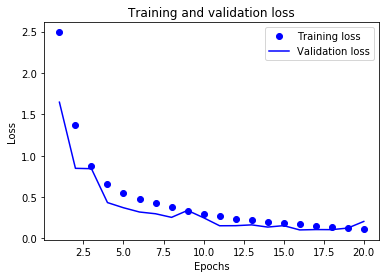

In [81]:
import matplotlib.pyplot as plt

history_dict = history.history 

loss_values = history_dict ['loss'] 

val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)



plt.plot(epochs, loss_values, 'bo', label='Training loss') 

plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 

plt.title('Training and validation loss') 

plt.xlabel('Epochs') 

plt.ylabel('Loss') 

plt.legend()

plt.show()

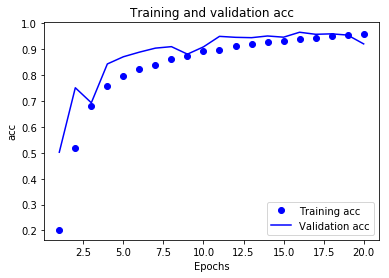

In [82]:
history_dict = history.history 

acc_values = history_dict ['acc'] 

val_acc_values = history_dict['val_acc']



plt.plot(epochs, acc_values, 'bo', label='Training acc') 

plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 

plt.title('Training and validation acc') 

plt.xlabel('Epochs') 

plt.ylabel('acc') 

plt.legend()

plt.show()